<a href="https://colab.research.google.com/github/jstephens/tideprediction/blob/main/Tide_Prediction_CNN_and_Regression_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
from collections import Counter
from datetime import datetime
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.model_selection import cross_val_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import normalize
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Reshape, Conv2DTranspose,Dropout, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.python.framework.errors_impl import ResourceExhaustedError

In [24]:
from google.colab import drive
drive.mount('/content/drive')

base_dir = 'drive/MyDrive/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
np.random.seed(42)

tf.random.set_seed(42)

# Data Load and Transformation

In [26]:
X_train = np.load(base_dir + 'source/X_train_surge_new.npz')
X_test = np.load(base_dir +'source/X_test_surge_new.npz')
Y_train = pd.read_csv(base_dir +'/source/Y_train_surge.csv',index_col = 'id_sequence')

df_X_test = pd.DataFrame.from_dict({item: X_test[item] for item in X_test.files}, orient='index').T.set_index('id_sequence')
df_X_train = pd.DataFrame.from_dict({item: X_train[item] for item in X_train.files}, orient='index').T.set_index('id_sequence')

In [27]:
def normalization(df):
  for i in range(len(df['slp'])):
      # Access the inner arrays
      inner_arrays = df['slp'].iloc[i]

      # Normalize each inner array
      normalized_inner_arrays = [normalize(arr) for arr in inner_arrays]

      # Update the DataFrame with the normalized inner arrays
      df['slp'].iloc[i] = normalized_inner_arrays

  return df

In [28]:
X_test = normalization(df_X_test)
X_train = normalization(df_X_train)

load_and_process_sequences shortens the dataframe contents enough to avoid ResourceExhaustedError from Keras. The last 10 frames of every third row are used to maximize the chances that feature extraction will occur on meaningful images without duplication of efforts.

In [29]:
def load_and_preprocess_sequences(df, use_shortened_data=True):
    new_data = df['slp'].apply(lambda x: x[-seqcount:])
    new_df = pd.DataFrame(new_data, columns=['slp']) 
    if use_shortened_data:
        image_sequences = np.array(new_df.iloc[::3]['slp'].values.tolist())
    else:
        image_sequences = np.array(new_df['slp'].values.tolist())
    image_sequences = image_sequences[:, -seqcount:]
    reshaped_sequences = image_sequences.reshape(-1, seqcount, 41, 41, 1)
    return reshaped_sequences

In [30]:
seqcount = 10

reshaped_seq_train = load_and_preprocess_sequences(X_train, use_shortened_data=True)
reshaped_seq_train_full = load_and_preprocess_sequences(X_train, use_shortened_data=False)
reshaped_seq_test = load_and_preprocess_sequences(X_test, use_shortened_data=False)

In [31]:
def flatten_array(row):
    new_row = []
    for col in row:
        if isinstance(col, np.ndarray):
            new_row.extend(col.ravel())
        else:
            new_row.append(col)
    return pd.Series(new_row)

def X_prep(df):
  included_columns = ['surge1_input','surge2_input']

  df = df[included_columns]
  expandedcol_list = []
  count = 0
  for x in included_columns:
    for count in range(10):
      expandedcol_list.append(f"{x}_{count}")

  df = df.apply(flatten_array, axis=1)
  df.columns = range(1, len(df.columns) + 1)
  df.columns = expandedcol_list
  return df

In [32]:
X_train = X_prep(X_train)
X_test = X_prep(X_test)

# GPU Maintenance

In [33]:
# Check if a GPU is available
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    # Configure TensorFlow to use the first GPU
    tf.config.set_visible_devices(gpus[0], 'GPU')
    tf.config.experimental.set_memory_growth(gpus[0], True)

# Regression Modeling

For each grid search iteration, and for each cluster, separate regression models were made and the results compiled and exported to CSV. The MultiOutputRegressor wrapper in scikit-learn was utilized for the 10-value output expected from each model.

In [34]:
def regression_model(cluster_train_labels, cluster_test_labels,clustercount,iteration):
  num_rows = len(X_test)

  X_train['Cluster'] = cluster_train_labels
  X_test['Cluster'] = cluster_test_labels
  cluster_scores = []

  data = np.zeros((num_rows, 20))  # initialize with zeros
  entire_y_pred_df = pd.DataFrame(data)
  entire_y_pred_df = entire_y_pred_df.set_index(X_test.index)

  for cluster_no in range(clustercount):
    c_X_train = X_train[X_train['Cluster'] == cluster_no].copy()
    c_X_test = X_test[X_test['Cluster'] == cluster_no].copy()
    c_y_train = Y_train.loc[c_X_train.index]

    # Create a multi-output linear regression model
    model = MultiOutputRegressor(LinearRegression())

    # Perform cross-validation
    scores = cross_val_score(model, c_X_train, c_y_train, cv=5, scoring='neg_mean_squared_error')
        
    # building out prediction file
    model.fit(c_X_train, c_y_train)
    y_pred = model.predict(c_X_test)
    y_pred_df = pd.DataFrame(y_pred)
    y_pred_df = y_pred_df.set_index(c_X_test.index)

    entire_y_pred_df.update(y_pred_df)
    # Calculate the mean squared error
    mean_mse = -scores.mean()
    cluster_scores.append(mean_mse)

  entire_y_pred_df.columns=Y_train.columns
  predictions_file = f"{base_dir}Predictions/{timestamp}_{iteration}_y_predictions_{cluster_no}_clusters.csv"

  entire_y_pred_df.to_csv(predictions_file)
  print(f"Iteration {iteration}: predictions for {cluster_no} clusters exported successfully.")
  avg_mse = np.mean(cluster_scores)
  median_mse = np.median(cluster_scores)
  mse_scores= [avg_mse, median_mse]

  return mse_scores

# Convolutional Neural Network 

## Helper Functions

calculate_value_percentage and check_value_percentage verifies that the clustering that occurred after feature extraction isn't distorted in favor of one party - any results where less than x% of the dataset can be seen in one cluster are discarded.

In [35]:
def calculate_value_percentage(lst):
    value_counts = Counter(lst)
    total_values = len(lst)
    value_percentages = {}

    for value, count in value_counts.items():
        percentage = (count / total_values) * 100
        value_percentages[value] = round(percentage,3)

    return value_percentages

def check_value_percentage(lst, x):
    value_percentages = calculate_value_percentage(lst)
    
    for percentage in value_percentages.values():
        if percentage < x:
            return False
    
    return True

export_grid_search_results collects all the relevant statistics for each parameter outcome, then by cluster, and exports it to CSV. Unsuccessful iterations - where the clustering couldn't be applied properly or there wasn't enough memory to test the set of parameters - are listed separately.

In [36]:
def export_grid_search_results(grid_search_df,unsuccessful_iterations,oom_list):
    summary_file_path = f'{base_dir}{timestamp}_summary_stats.csv'

    grid_search_df.to_csv(summary_file_path, index=False, sep=',')
    
    output = '\n\n\n\n'
    if len(unsuccessful_iterations) >= 1:
      output += '\nUnsuccessful Parameter Combinations:'
      for unsuccessful_item in unsuccessful_iterations:
        output += f'\n{unsuccessful_item}'
    
    if len(oom_list) >= 1:
      output += '\nInsufficient Memory:'
      for oom_item in oom_list:
        output += f'\n{oom_item}'

    with open(summary_file_path, "a") as file:
      file.write(output)
    
    print("Grid search summary successfully exported.")

createfigure exported successful clustering results to a matplotlib plot for easier comparison.

In [37]:
def createfigure(reshaped_latent_space,cluster_labels,cluster,iteration):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Scatter plot
    scatter = ax.scatter(reshaped_latent_space[:, 0],
                         reshaped_latent_space[:, 1],
                         reshaped_latent_space[:, 2],
                         c=cluster_labels,
                         cmap='viridis')

    # Customize the plot
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_zlabel('Feature 3')
    ax.set_title('Clustering')
    # Add a colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Cluster Labels')
    # Save the plot
    plt.savefig(f'{timestamp}_{iteration}_{cluster}c_Clustering.png')

## Grid Search

In [38]:
def create_autoencoder_model(latent_dim, conv1_filters, conv2_filters, dropout_rate, l_r):
    input_shape = (seqcount, 41, 41, 1)
    inputs = Input(shape=input_shape)
    x = TimeDistributed(Conv2D(conv1_filters, 5, activation='softmax', padding='same'))(inputs)
    x = TimeDistributed(Conv2D(conv2_filters, 5, activation='softmax', padding='same'))(x)
    x = TimeDistributed(Flatten())(x)
    x = TimeDistributed(Dropout(dropout_rate))(x)
    latent = TimeDistributed(Dense(latent_dim, activation='softmax'))(x)
    x = TimeDistributed(Dense(np.prod((41, 41, 64)), activation='softmax'))(latent)
    x = TimeDistributed(Reshape((41, 41, 64)))(x)
    x = TimeDistributed(Conv2DTranspose(32, 5, activation='softmax', padding='same'))(x)
    outputs = TimeDistributed(Conv2DTranspose(1, 5, activation='sigmoid', padding='same'))(x)
    autoencoder = Model(inputs, outputs)
    optimizer = Adam(learning_rate=l_r)
    autoencoder.compile(optimizer=optimizer, loss='mse')
    return autoencoder

In [46]:
def perform_grid_search(param_grid, num_iterations,use_lin_reg):
    
    exportdf_columns = ['Iteration No','Latent Dimensions','Batch Size','Epochs',
               'Conv1 Filters','Conv2 Filters','Dropout Rate','Learning Rate',
               'Clusters','Cluster Percentages','Silhouette Score - Train','Calinski Score - Train',
               'Davies Bouldin Score - Train','Avg MSE','Median MSE',
               'Silhouette Score - Test','Calinski Score - Test','Davies Bouldin Score - Test']

    grid_search_results = pd.DataFrame(columns=exportdf_columns)
    unsuccessful_iterations = []
    oom_list = []
    for iteration_no in range(num_iterations):
        iteration_no += 1
        print(f"Iteration {iteration_no} of {num_iterations}")
        try:
            params = {
                'latent_dim': random.choice(param_grid['latent_dim']),
                'batch_size': random.choice(param_grid['batch_size']),
                'epochs': random.choice(param_grid['epochs']),
                'conv1_filters': random.choice(param_grid['conv1_filters']),
                'conv2_filters': random.choice(param_grid['conv2_filters']),
                'dropout_rate': random.choice(param_grid['dropout_rate']),
                'learning_rate': random.choice(param_grid['learning_rate'])
            }
            print(params)
            autoencoder_model = create_autoencoder_model(params['latent_dim'], params['conv1_filters'],
                                                         params['conv2_filters'], params['dropout_rate'],
                                                         params['learning_rate'])
            early_stopping = EarlyStopping(monitor='loss', patience=3)
            autoencoder_model.fit(reshaped_seq_train_full, reshaped_seq_train_full, epochs=params['epochs'],
                                  batch_size=params['batch_size'], callbacks=[early_stopping], verbose=1)

            encoder = Model(autoencoder_model.input, autoencoder_model.layers[-5].output)
            latent_space = encoder.predict(reshaped_seq_train_full)
            reshaped_latent_space_train = latent_space.reshape(-1, seqcount * params['latent_dim'])
            for desired_cluster in range(2, 8):
                kmeans = KMeans(n_clusters=desired_cluster, random_state=42, n_init='auto')
                cluster_labels_train = kmeans.fit_predict(reshaped_latent_space_train)
                c = np.savetxt(f'{timestamp}_{iteration_no}_{desired_cluster}c_labels.txt', reshaped_latent_space_train, delimiter =', ')
                percentage_threshold = 5
                try:
                    if len(set(cluster_labels_train)) == desired_cluster and check_value_percentage(cluster_labels_train, percentage_threshold):
                        if use_lin_reg == True:
                            latent_space_test = encoder.predict(reshaped_seq_test)
                            reshaped_latent_space_test = latent_space_test.reshape(-1, seqcount * params['latent_dim'])
                            cluster_labels_test = kmeans.fit_predict(reshaped_latent_space_test)
                            mse_scores = regression_model(cluster_labels_train,cluster_labels_test,desired_cluster,iteration_no)

                        cluster_percents = calculate_value_percentage(cluster_labels_train)
                        silhouette_avg = silhouette_score(reshaped_latent_space_train, cluster_labels_train)
                        ch_score = calinski_harabasz_score(reshaped_latent_space_train, cluster_labels_train)
                        db_score = davies_bouldin_score(reshaped_latent_space_train, cluster_labels_train)

                        silhouette_avg_test = silhouette_score(reshaped_latent_space_test, cluster_labels_test)
                        ch_score_test = calinski_harabasz_score(reshaped_latent_space_test, cluster_labels_test)
                        db_score_test = davies_bouldin_score(reshaped_latent_space_test, cluster_labels_test)
                        d = np.savetxt(f'{timestamp}_{iteration_no}_{desired_cluster}c_reshaped_latent_space_train.txt', reshaped_latent_space_train, delimiter =', ')
                        try:
                            createfigure(reshaped_latent_space_train,cluster_labels_train,desired_cluster,iteration_no)
                        except Exception as e:
                            print(e)
                            print("PLT figure failed.")
                        
                        results_list = [iteration_no,params['latent_dim'],params['batch_size'],params['epochs'],
                                           params['conv1_filters'],params['conv2_filters'],params['dropout_rate'],
                                           params['learning_rate'],desired_cluster,cluster_percents,silhouette_avg,ch_score,db_score,
                                           mse_scores[0],mse_scores[1],silhouette_avg_test,ch_score_test,
                                           db_score_test]

                        clustering_df = pd.DataFrame([results_list], columns=grid_search_results.columns)

                        grid_search_results = grid_search_results.append(clustering_df, ignore_index=True)
                    else:
                        unsuccessful_iterations.append([params,f"Clustering didn't work for {desired_cluster}"])

                except Exception as e:
                    print(e)
                    unsuccessful_iterations.append([params,e])
                    continue

        except ResourceExhaustedError:
            oom_list.append(params)
            print(f"Resource Exhausted Error for {params}")
            continue

    export_grid_search_results(grid_search_results,unsuccessful_iterations,oom_list)

Iteration 1 of 1
{'latent_dim': 128, 'batch_size': 32, 'epochs': 30, 'conv1_filters': 200, 'conv2_filters': 300, 'dropout_rate': 0.6, 'learning_rate': 0.0001}
Epoch 1/30
175/175 [==============================] - 19s 96ms/step - loss: 0.0906
Epoch 2/30
175/175 [==============================] - 17s 95ms/step - loss: 0.0459
Epoch 3/30
175/175 [==============================] - 17s 95ms/step - loss: 0.0233
Epoch 4/30
175/175 [==============================] - 17s 95ms/step - loss: 0.0123
Epoch 5/30
175/175 [==============================] - 17s 95ms/step - loss: 0.0069
Epoch 6/30
175/175 [==============================] - 17s 95ms/step - loss: 0.0041
Epoch 7/30
175/175 [==============================] - 17s 95ms/step - loss: 0.0027
Epoch 8/30
175/175 [==============================] - 17s 95ms/step - loss: 0.0019
Epoch 9/30
175/175 [==============================] - 17s 95ms/step - loss: 0.0015
Epoch 10/30
175/175 [==============================] - 17s 95ms/step - loss: 0.0013
Epoch 11/3

<ipython-input-46-b16c9e276004>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_search_results = grid_search_results.append(clustering_df, ignore_index=True)


16/16 [==============================] - 0s 25ms/step
Iteration 1: predictions for 2 clusters exported successfully.


<ipython-input-46-b16c9e276004>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_search_results = grid_search_results.append(clustering_df, ignore_index=True)


16/16 [==============================] - 0s 25ms/step
Iteration 1: predictions for 3 clusters exported successfully.


<ipython-input-46-b16c9e276004>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_search_results = grid_search_results.append(clustering_df, ignore_index=True)


16/16 [==============================] - 0s 25ms/step
Iteration 1: predictions for 4 clusters exported successfully.


<ipython-input-46-b16c9e276004>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_search_results = grid_search_results.append(clustering_df, ignore_index=True)


16/16 [==============================] - 0s 26ms/step
Iteration 1: predictions for 5 clusters exported successfully.


<ipython-input-46-b16c9e276004>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_search_results = grid_search_results.append(clustering_df, ignore_index=True)


16/16 [==============================] - 0s 24ms/step
Iteration 1: predictions for 6 clusters exported successfully.


<ipython-input-46-b16c9e276004>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_search_results = grid_search_results.append(clustering_df, ignore_index=True)


Grid search summary successfully exported.


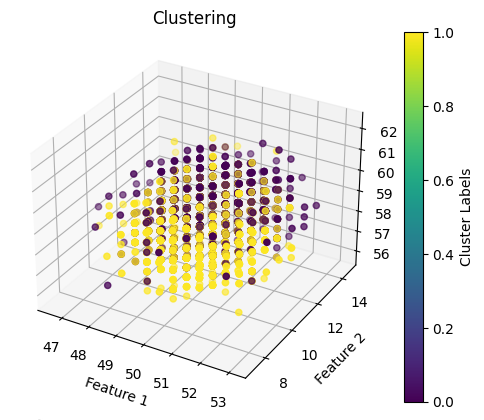

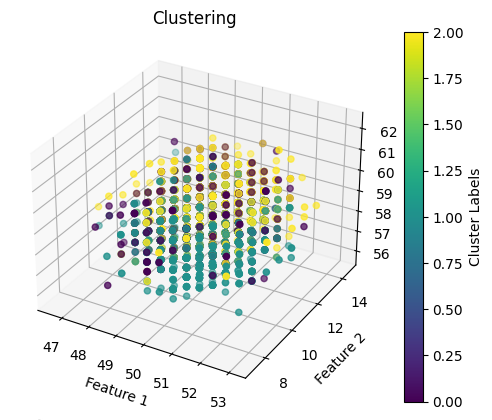

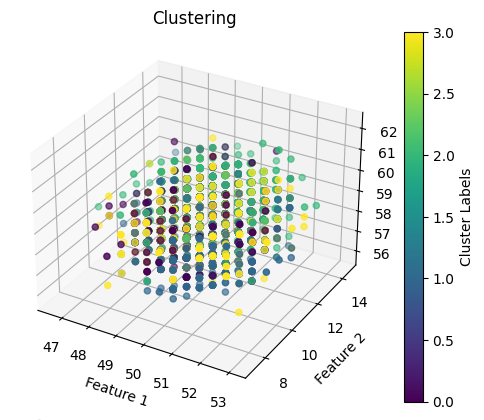

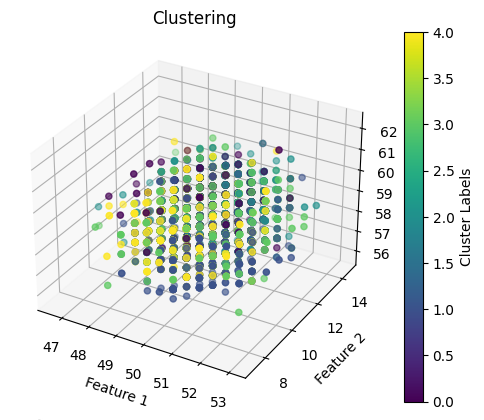

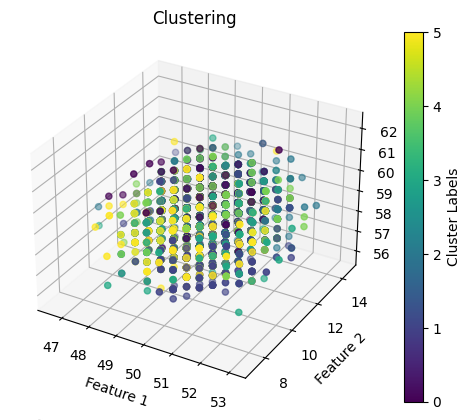

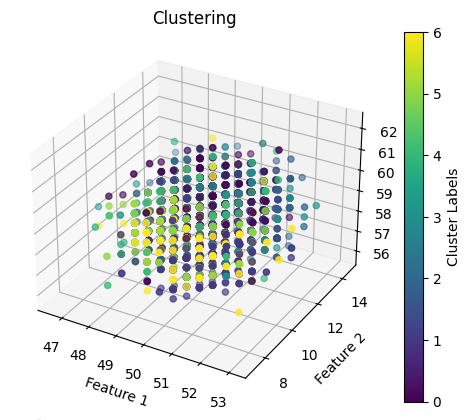

In [47]:
# Create the parameter grid for hyperparameter tuning
param_grid = {
    'latent_dim': [64, 128, 256],
    'batch_size': [32, 64, 128],
    'epochs': [10, 20, 30],
    'conv1_filters': [100, 200, 300,350],
    'conv2_filters': [100, 200, 300,350],
    'dropout_rate': [0.2, 0.4, 0.6],
    'learning_rate': [0.01, 0.001, 0.0001],
}

best_params = {
    'latent_dim': [128],
    'batch_size': [32],
    'epochs': [30],
    'conv1_filters': [200],
    'conv2_filters': [300],
    'dropout_rate': [0.6],
    'learning_rate': [0.0001],

}

num_iterations = 1
timestamp = datetime.datetime.now()
timestamp = timestamp.strftime("%Y_%m_%d_%H%M%S")

perform_grid_search(best_params, num_iterations,True)